In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import re, pickle
from datetime import datetime
import scipy, itertools
import scipy.stats
#For random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


In [2]:
t14_cases = pickle.load(open('estimates.pickle','rb'))['t14_cases']
t14_recovered = pickle.load(open('estimates.pickle','rb'))['t14_recovered']
estimated_cases = pickle.load(open('estimates.pickle','rb'))['estimated_cases']
estimated_recovered = pickle.load(open('estimates.pickle','rb'))['estimated_recovered']
cases_added = pickle.load(open('time_series.pickle','rb'))['cases_added'].loc[estimated_cases.index]
cases_full = pickle.load(open('time_series.pickle','rb'))['cases_full'].loc[estimated_cases.index]
ecbd = pickle.load(open('time_series.pickle','rb'))['ECBD'].loc[estimated_cases.index]


In [3]:
fips = pd.read_excel('fips_data.xlsx')[1:]
fips['lat'] = fips.apply(lambda x: float(re.sub('–','-',str(x['Latitude'])[:-1])),axis=1)
fips['lon'] = fips.apply(lambda x: float(re.sub('–','-',str(x['Longitude'])[:-1])),axis=1)
fips['index'] = fips['FIPS']


In [4]:
testing = pd.read_csv('states_daily_4pm_et.csv')
testing['datetime'] = testing.apply(lambda x: datetime.strptime(str(x['date']),'%Y%m%d'),axis=1)
testing['number_of_tests'] = testing['positive']+testing['negative']


#### Section 1

In [5]:
date = list(estimated_cases)[-1]
merged = pd.merge(estimated_cases[[date]].reset_index(),estimated_recovered[[date]].reset_index(),on='index').set_index('index')
merged['total'] = merged.sum(axis=1)
merged = pd.merge(merged.reset_index(),fips[['index','County\xa0[2]','Land Area','State']],how='left',on='index').set_index('index')
merged = pd.merge(merged.reset_index(),cases_added[[date]].set_index(pd.Index(cases_full.index.values)).reset_index(),how='left',on='index')
merged = merged[['index','total','County\xa0[2]','State',date]].reset_index(drop=True)
merged.columns = ['FIPS','Estimated','County','State','Reported']
merged = merged[['FIPS','State','County','Reported','Estimated']].sort_values(by='Estimated',ascending=False)
merged['Estimated'] = merged['Estimated'].astype(int)
merged.head(12)

ecbd = ecbd*(100/1.38)


#### Section 2

In [6]:
testing_to_merge = testing[['datetime','state','number_of_tests']]
testing_to_merge.columns = ['level_0','State','tests']

features = pd.merge(estimated_cases.transpose().stack().reset_index(),estimated_recovered.transpose().stack().reset_index(),on=['level_0','level_1'])
features.columns = ['level_0','FIPS','ecases','erecovered']
features = pd.merge(features,ecbd.transpose().stack().reset_index(),how='left',on=['level_0','FIPS'])
features = pd.merge(cases_full.transpose().stack().reset_index(),features,on=['level_0','FIPS'])
features = pd.merge(features,fips[['FIPS','State','Population']],how='left',on='FIPS') 
features = pd.merge(features,testing_to_merge,how='left',on=['level_0','State']).fillna(0)

features['estimated'] = features['ecases']#+features['erecovered']
features = features.drop(['FIPS','ecases','erecovered'],axis=1)
features.columns = ['date','r','fdce','state','p','t','estimated']

features = features.groupby(['date','state']).sum().reset_index()
features = features[features['state'] != 0]

In [7]:
#setting features

features['label'] = features['r']/(features['t'])
features['e0'] = features['r']
features['e1'] = features['fdce']
features['e2'] = features['estimated']
features['rp'] = features['r']/features['p']
features['re0'] = features['r']/features['e0']
features['re1'] = features['r']/features['e1']
features['re2'] = features['r']/features['e2']
features['e0p'] = features['e0']/features['p']
features['e1p'] = features['e1']/features['p']
features['e2p'] = features['e2']/features['p']

features = features.replace([-np.inf,np.inf], np.nan)
features = features.fillna(0)
features_store = features.copy()


In [28]:
#only testing on areas with significant testing
features = features[features['t']>10000]

In [29]:
import warnings
warnings.filterwarnings('ignore')

E0 = []
E1 = []
E2 = []

for s in set(features['state']):
    
    to_test = [s]
    print(to_test)
    
    ################################################## NEW RF MODEDL WITH E0
    
    train = features[~features['state'].isin(to_test)][['p','r','e0','rp','re0','e0p','label']]
    train = train[features['date'].isin(list(ecbd))]
    train_labels = train.pop('label')
    test = features[features['state'].isin(to_test)][['p','r','e0','rp','re0','e0p','label']]
    test = test[features['date'].isin(list(ecbd))]
    test_labels = test.pop('label')

    regressor = RandomForestRegressor(max_depth = 5,n_estimators= 100, random_state = 1, criterion = 'mae',bootstrap=True,n_jobs=-1,max_features='auto')

    X = np.array(train)

    regress = regressor.fit(X,train_labels.values)
    
    predictions0 = regress.predict(np.array(test))
    lineregress_test = scipy.stats.linregress(predictions0,test_labels)
    E0.append(lineregress_test[2])
    
    
    #################################################### NEW RF MODEL WITH E1
    
    train = features[~features['state'].isin(to_test)][['p','r','e1','rp','re1','e1p','label']]
    train = train[features['date'].isin(list(ecbd))]
    train_labels = train.pop('label')

    test = features[features['state'].isin(to_test)][['p','r','e1','rp','re1','e1p','label']]
    test = test[features['date'].isin(list(ecbd))]
    test_labels = test.pop('label')

    regressor = RandomForestRegressor(max_depth = 5,n_estimators= 100, random_state = 1, criterion = 'mae',bootstrap=True,n_jobs=-1,max_features='auto')

    X = np.array(train)

    regress = regressor.fit(X,train_labels)
    
    predictions1 = regress.predict(np.array(test))
    lineregress_test = scipy.stats.linregress(predictions1,test_labels)
    E1.append(lineregress_test[2])
    
    ################################################## NEW RF MODEL WITH E2
    
    train = features[~features['state'].isin(to_test)][['p','r','e2','rp','re2','e2p','label']]
    train = train[features['date'].isin(list(ecbd))]
    train_labels = train.pop('label')

    test = features[features['state'].isin(to_test)][['p','r','e2','rp','re2','e2p','label']]
    test = test[features['date'].isin(list(ecbd))]
    test_labels = test.pop('label')

    regressor = RandomForestRegressor(max_depth = 5,n_estimators= 100, random_state = 1, criterion = 'mae',bootstrap=True,n_jobs=-1,max_features='auto')

    X = np.array(train)

    regress = regressor.fit(X,train_labels)
    
    predictions2 = regress.predict(np.array(test))
    lineregress_test = scipy.stats.linregress(predictions2,test_labels)
    E2.append(lineregress_test[2])


['MI']
['MS']
['MN']
['ME']
['KY']
['TX']
['TN']
['KS']
['CO']
['NH']
['NJ']
['AR']
['SD']
['ND']
['NE']
['RI']
['WA']
['LA']
['MA']
['VT']
['WV']
['VA']
['DE']
['OR']
['CA']
['NV']
['NY']
['IA']
['AL']
['AZ']
['HI']
['SC']
['GA']
['ID']
['CT']
['UT']
['MT']
['PA']
['AK']
['IN']
['OH']
['MO']
['OK']
['WY']
['IL']
['WI']
['MD']
['FL']
['NC']
['NM']
['DC']


In [30]:
compare_values = pd.DataFrame()
compare_values['E2'] = [x**2 for x in E2]
compare_values['E1'] = [x**2 for x in E1]
compare_values['E0'] = [x**2 for x in E0]

for triple in itertools.permutations(['E2','E1','E0']):
    total = compare_values.apply(lambda x: 1 if x[triple[0]] >=  x[triple[1]] >= x[triple[2]] else 0,axis=1).sum()
    print(triple,total)

compare_values['sig'] = compare_values.apply(lambda x: 1 if max(x['E2'],x['E1'],x['E0']) >= .25  else 0,axis=1)


('E2', 'E1', 'E0') 18
('E2', 'E0', 'E1') 13
('E1', 'E2', 'E0') 0
('E1', 'E0', 'E2') 8
('E0', 'E2', 'E1') 9
('E0', 'E1', 'E2') 3


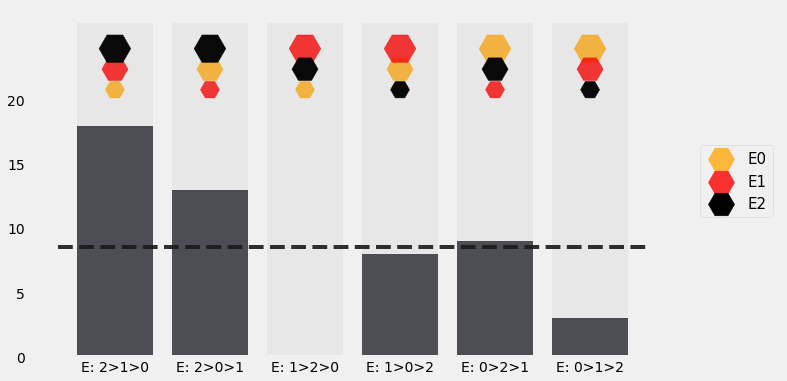

In [31]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
sequence1 = np.array([30,30,28,26,28,26])*.8
sequence2 = np.array([28,26,30,30,26,28])*.8
sequence3 = np.array([26,28,26,28,30,30])*.8

plt.scatter([0,1,2,3,4,5],sequence3,marker='H',s=[200*(x-19) for x in sequence3],color='orange',alpha=.75,label='E0')
plt.scatter([0,1,2,3,4,5],sequence2,marker='H',s=[200*(x-19) for x in sequence2],color='red',alpha=.8,label='E1')
plt.scatter([0,1,2,3,4,5],sequence1,marker='H',s=[200*(x-19) for x in sequence1],color='black',label='E2')

vals = []
for triple in itertools.permutations(['E2','E1','E0']):
    total = compare_values.apply(lambda x: 1 if x[triple[0]] >=  x[triple[1]] >= x[triple[2]] else 0,axis=1).sum()
    compare_values[triple] = compare_values.apply(lambda x: 1 if x[triple[0]] >= x[triple[1]] >= x[triple[2]] else 0,axis=1)
    vals.append(total)


plt.bar([0,1,2,3,4,5],[26 for i in range(6)],alpha=.075,color='gray')
plt.plot([-.6,5.6],[8.5,8.5],color=(.1,.1,.1),alpha=.9,linestyle='dashed')
plt.bar([0,1,2,3,4,5],compare_values.sum()[4:].values,color=(.1,.1,.15),alpha=.75)
plt.grid(False)
plt.xticks([0,1,2,3,4,5,7],['E: 2>1>0','E: 2>0>1','E: 1>2>0','E: 1>0>2','E: 0>2>1','E: 0>1>2',''])
plt.yticks([0,5,10,15,20])
plt.legend(loc='center right',prop={'size': 15})

plt.show()



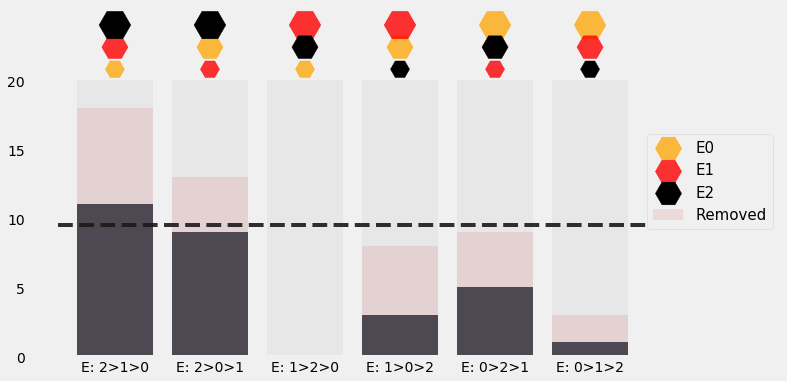

In [38]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,6))
sequence1 = np.array([30,30,28,26,28,26])*.8
sequence2 = np.array([28,26,30,30,26,28])*.8
sequence3 = np.array([26,28,26,28,30,30])*.8

plt.scatter([0,1,2,3,4,5],sequence3,marker='H',s=[200*(x-19) for x in sequence3],color='orange',alpha=.75,label='E0')
plt.scatter([0,1,2,3,4,5],sequence2,marker='H',s=[200*(x-19) for x in sequence2],color='red',alpha=.8,label='E1')
plt.scatter([0,1,2,3,4,5],sequence1,marker='H',s=[200*(x-19) for x in sequence1],color='black',label='E2')

vals = []
for triple in itertools.permutations(['E2','E1','E0']):
    total = compare_values.apply(lambda x: 1 if x[triple[0]] >=  x[triple[1]] >= x[triple[2]] else 0,axis=1).sum()
    compare_values[triple] = compare_values.apply(lambda x: 1 if x[triple[0]] >=  x[triple[1]] >= x[triple[2]] else 0,axis=1)
    vals.append(total)


plt.bar([0,1,2,3,4,5],[20 for i in range(6)],alpha=.075,color='gray')
plt.plot([-.6,5.6],[compare_values[compare_values['sig']==1].sum()[3:-1].sum()/6,compare_values[compare_values['sig']==1].sum()[3:-1].sum()/6],color=(.1,.1,.1),alpha=.9,linestyle='dashed')
plt.bar([0,1,2,3,4,5],compare_values.sum()[4:].values,color=(.8,.1,.15),alpha=.1,label='Removed')
plt.bar([0,1,2,3,4,5],compare_values[compare_values['sig']==1].sum()[4:].values,color=(.1,.1,.15),alpha=.75)
plt.grid(False)
plt.xticks([0,1,2,3,4,5,7],['E: 2>1>0','E: 2>0>1','E: 1>2>0','E: 1>0>2','E: 0>2>1','E: 0>1>2',''])
plt.yticks([0,5,10,15,20])
plt.legend(loc='center right',prop={'size': 15})

plt.show()


In [40]:
scipy.stats.chisquare(compare_values[compare_values['sig']>0].sum()[4:].values)

Power_divergenceResult(statistic=20.034482758620687, pvalue=0.0012312458708606205)

In [34]:
scipy.stats.binom_test(20,29)/2

0.03071417286992074